# NOISY DIGITS LOCALIZATION & CLASSIFICATION 

The goal of this project is to design and evaluate a deep neural network for (1) localizing and (2) classifying handwritten digits in images, where the digits aren't necessarily centered inside the images, and different noise types could be applied to them.

The stages of the project will be as follows:

1) Data preparation - Loading a handwritten digits dataset (the MNIST dataset) and expanding the images, such that the digits are placed randomly inside a larger image.

2) Model development - Designing and training the deep learning model, and explaining the reasoning behind the different development decisions.

3) Performance evaluation - Evaluating the performance of the model in the localization and classification tasks, especially under the application of different noise types. Then suggesting performance improvement strategies.

4) Model deployment - Planning how to deploy the model at the front-end and the back-end, and how to deal with potential congestion issues.

# 0) Initializaing

Connecting to a local runtime:

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

## Importing modules

In [ ]:
# Operating system
import os

# Data
from keras.datasets import mnist
import pandas as pd
import copy
import enum

# Mathematics
import numpy as np

# Machine learning
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import keras
from keras.models import Sequential, Model # Sequential & functional APIs
from keras.layers import InputLayer, Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tensorflow.keras.utils import plot_model
from keras.models import save_model, load_model
tf.config.run_functions_eagerly(True)

import cv2

# Visualization
import matplotlib.pyplot as plt

## Choosing settings

In [ ]:
# Working directory
is_runtime_local = True # True for local runtime, False for a hosted runtime on Google Colab
working_dir_local = "C:/Sergey\'s Google Drive/Colab Notebooks/Noisy digits project/"
working_dir_hosted = "/content/drive/My Drive/Colab Notebooks/Noisy digits project/"

# Data settings
image_len_expand = 48 # Expanded image length in pixels

# Sections to run settings
evaluate_model_flag = True # Run model evaluation sections

# Output settings
pd.set_option('display.width', 500) # For presenting full dataframes
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)
font_size = 16
tick_size = font_size - 2

# Randomization settings
use_fixed_random_seed = True # Use fixed randomization
random_seed_value = 0

In [ ]:
# Setting working directory
if is_runtime_local:
    os.chdir(working_dir_local)
else:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(working_dir_hosted)

print('Current working directory:')
print(os.getcwd())

Current working directory:
C:\Sergey's Google Drive\Colab Notebooks\Noisy digits project


## Setting randomization

In [ ]:
# Adjusting randomization
if use_fixed_random_seed:
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED'] = str(random_seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(random_seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(random_seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    # tf.random.set_seed(random_seed_value)

    # For later versions: 
    tf.compat.v1.set_random_seed(random_seed_value)

    # 5. Configure a new global `tensorflow` session
    from keras import backend as K

    # For later versions:
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

# 1) Preparing dataset

## a. Expanding images

### Defining functions

In [ ]:
def expand_mnist_images(image_len_expand, return_center_xy=True, highlight_loc_xy=False):
    '''
    The function loads the MNIST dataset and returns larger images,
    into which the MNIST digits are randomly (uniformly) inserted.
    In addition, it returns the (x,y) coordinate of the insertion.
    The length of the larger image in pixels is determined by image_len_expand,
    where it is assumed the image is square.
    '''

    # Loading the MNIST dataset
    (train_X_og, train_y), (test_X_og, test_y) = mnist.load_data()

    # Calculating variables
    X = np.concatenate((train_X_og, test_X_og), axis=0)
    train_samples_num = train_X_og.shape[0]
    samples_num = X.shape[0]
    image_len_data = X.shape[1] # Image length in the original data

    # Expanding images
    if image_len_expand >= image_len_data:
        X_expanded = np.zeros([samples_num, image_len_expand, image_len_expand])
        # The (x,y) coordinate of the upper-left corner of the smaller image inside the expanded image
        location_xy = np.zeros((samples_num, 2), dtype=int) 

        for i in range(0, X.shape[0]):
            expanded_image = np.zeros((image_len_expand, image_len_expand))
            # Randomizing a coordinate where the upper-left corner of the smaller image will be in the larger image
            x, y = np.random.randint(0, image_len_expand-image_len_data+1, size=2) # High boundary is excluded
            # Inserting the original image. Notice x becomes the column and y the row
            expanded_image[y:y+image_len_data, x:x+image_len_data] = X[i]
            if return_center_xy: # Returning the coordinate of the center of the digit
                x, y = int(x + image_len_data/2), int(y + image_len_data/2)
            if highlight_loc_xy:
                expanded_image[y,x] = 255
            
            # Saving
            X_expanded[i] = expanded_image
            location_xy[i,0], location_xy[i,1] = x, y

        train_X = X_expanded[0:train_samples_num]
        test_X = X_expanded[train_samples_num:]
        train_loc = location_xy[0:train_samples_num]
        test_loc = location_xy[train_samples_num:]

    else:
        print('The specified output length is smaller than that of the data set.')
        print(f'Please choose a value less than or equal to {image_len_data}.\n')

    return train_X_og, train_y, test_X_og, test_y, \
        train_X, train_loc, test_X, test_loc

In [ ]:
def compare_images(image_1, title_1, image_2, title_2):
    ''' Plots 2 input images side by side. '''
    
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    axes[0].imshow(image_1, cmap=plt.get_cmap('gray'))
    axes[0].set_title(title_1)
    axes[1].imshow(image_2, cmap=plt.get_cmap('gray'))
    axes[1].set_title(title_2)
    plt.show()
    print()

    return

### Expanding images

In [ ]:
# Expanding images
train_X_og, train_y, test_X_og, test_y, \
train_X, train_loc, test_X, test_loc = \
    expand_mnist_images(image_len_expand = image_len_expand,
                        return_center_xy = True,
                        highlight_loc_xy = False)

In [ ]:
# Verifying dimensions
print('Dimensions of original data:')
print('train_X_og:', train_X_og.shape)
print('train_y:', train_y.shape)
print('test_X_og:', test_X_og.shape)
print('test_y:', test_y.shape, '\n')

print('Dimensions of generated data:')
print('train_X:', train_X.shape)
print('train_loc:', train_loc.shape)
print('test_X:', test_X.shape)
print('test_loc:', test_loc.shape)

Dimensions of original data:
train_X_og: (60000, 28, 28)
train_y: (60000,)
test_X_og: (10000, 28, 28)
test_y: (10000,) 

Dimensions of generated data:
train_X: (60000, 48, 48)
train_loc: (60000, 2)
test_X: (10000, 48, 48)
test_loc: (10000, 2)


Presenting example expanded images

Presenting sample number 6252.
Original image size: 28x28.
Expanded image size: 48x48.
Insertion coordinate of the original image in the expanded image:
(25, 33)



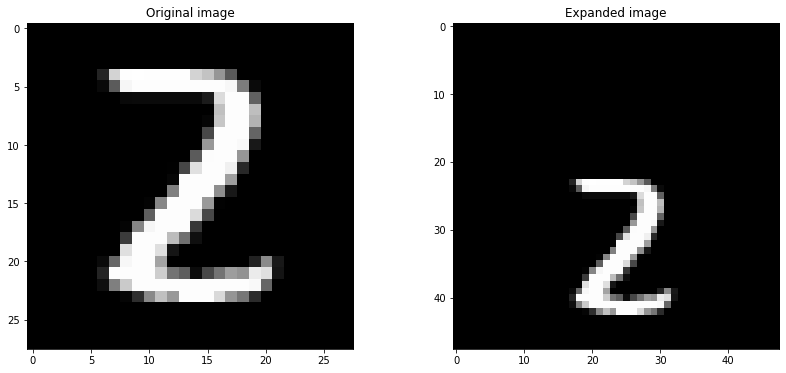

In [ ]:
# Presenting example expanded images
i = np.random.randint(0, len(train_X))

print(f'Presenting sample number {i}.')
print(f'Original image size: {train_X_og.shape[1]}x{train_X_og.shape[1]}.')
print(f'Expanded image size: {image_len_expand}x{image_len_expand}.')
print('Insertion coordinate of the original image in the expanded image:')
print(f'({train_loc[i,0]}, {train_loc[i,1]})\n')

compare_images(image_1 = train_X_og[i], title_1 = 'Original image',
               image_2 = train_X[i], title_2 = 'Expanded image')

# 2) Developing model

## a. Explaining reasoning

My model development was structured as follows:

- The goal was to design a multi-output network, which for a given expanded (as opposed to cropped) image with a digit, would predict the location of the digit, and classify its type (0-9). Thus the net will start with a main branch of layers, which will split into 2 output branches. My initial main concern was therefore to find an architecture for the main shared branch, which would accommodate both prediction types.

- My metrics of choise to track the performance with were categorical accuracy for classification and mean absolute error for localization, due to its straightforward interpretability and because its less effected by outliers in comparison to the mean squared error.

- For a sanity check and for saving time on initial debugging, I started with an image size of 28, and gradually increased it to 38 and 48, since part of the goal is to eventually deal well with larger images.

- Model-wise, I started by treating the simplest subproblem - digit classification in the original images. This taught me which architecture and hyperparameters are required to solve it in a satisfying manner, and in addition allowed me to plan my time allocation. The obtained weighted categorical accuracy was 98.1% on the training data (0.8 of the 60k training samples) and 98.5% on the validation set (the remaining 0.2 of the 60k samples).

- Then I proceeded to classifying digits in the expanded image, verifying the architecture I found works and there are no weird surprises. The final weighted categorical accuracy was - training: 97.99%, validation: 98.2%.

- Next, I trained a model for localizing the digits in the expanded images, by using the same architecture with a diffrent output layer and loss function, to accommodate the different task. No need for big modifications was found. The final mean absolute error was - training: 0.0414, validation: 0.0205.

- Finally, I trained the composite model. It starts with one input - the expanded images. These go through a convolutional net, whose output is split to 2 branches. One output branch predicts the location of the digit and the second classifies its type. The final mean absolute error was - training: 0.0397, validation: 0.0304. The final categorical accuracy was - training: 95.76%, validation: 97.53%.

- I tried a second composite network, but the performance of the first composite net was comparable and satisfactory, so I continued working with it, and learned that the idea behind it isn't crucial for success in our base problem. The obtained categorical accuracy on the validation data was 97.53% vs. 98.1%, and on the test data  was 98.04% vs. 98.11% (see next question). In the second composite NN, I first localize the digits and then utilize the localization result (use it as an extra input) to perform the classification. The intuition comes from how humans solve our task - we first look for the general location of an object before further investigating its identity, which is further motivated by knowing that classifying the original small images can be performed very well. Moreover, this idea is motivated by knowing that noises can appear in the image, since without noises the ability to classify the original images transfers directly to classifying them in the expanded images, without a difficulty in localization.

The guiding principals in the choice of the architecture and hyperparameters were as follows:

- The ultimate goal was preventing underfitting, which is expressed by minimizing the mean squared error for the localization problem and the categorical crossentropy for the classification problem, while also preventing overfitting. 

- To prevent underfitting, I selected a network appropriate for the task, in this case a convolutional network achieves great results in extracting features from images, and increased its complexity, reaching a number of trainable parameters which was at the same order of magnitude as that of the number of the training samples. Convergence of the loss function to a local minima was sped up by training with mini-batches and using an adaptive learning rate optimizer.

- To prevent overfitting, I utilized dropout layers and early stopping, to train for as long as possible while not memorizing the data.

- When designing the network, I followed best practices based on architectures that are known to achieve good results, e.g. LeNet, AlexNet and VGG. In particular I chose relu activation functions and "same" padding in the convolutional layers. The net starts with convolutional layers, whose number of filters keeps increasing and filter sizes decrease, to extract increasingly more and finer visual features. Between the layers, I applied max pooling to reduce the output dimensions, which is a better practice than average pooling. Finally, fully-connected layers are placed, where the number of units and activation function in the final layer match the prediction target.

## b. Training model

### Defining functions

In [ ]:
def train_model(
    model, outputs_names, X_train, Y_train,
    train_model_flag, save_model_flag, load_model_flag, model_path,
    training_epochs, training_batch_size, training_validation_split,
    training_targets_weights, training_verbose, training_callbacks,
    show_model_summary, 
    plot_training_loss, plot_training_metric, plot_training_metric_names, plot_log_scale):
    ''' Training a neural network model and presenting the training results. '''

    # Initializing variables
    train_history = None
    
    # Creating model directory
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # Presenting model summary
    if show_model_summary:
        print('Presenting model summary:\n')
        model.summary()
        print()

    # Training the model
    if train_model_flag:
        train_history = model.fit(
            x = X_train,
            y = Y_train,
            epochs = training_epochs,
            batch_size = training_batch_size,
            validation_split = training_validation_split,
            shuffle = True, # True by default
            class_weight = training_targets_weights,
            verbose = training_verbose,
            callbacks = training_callbacks # Includes early stopping
            )
        train_history_dict = train_history.history # Converting to a dictionary
        if training_verbose > 0:
            print()

    # Saving model
    if train_model_flag and save_model_flag:
        save_model(model, model_path)
        print()
        print('Saving model to:')
        print(model_path, '\n')
        
    # Loading model
    if load_model_flag:
        model = load_model(model_path)
        print('Loading model from:')
        print(model_path, '\n')

    # Plotting training history
    if train_model_flag:
        if len(outputs_names) < 2:
            if plot_training_loss or plot_training_metric:
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

            # Plotting training loss
            if plot_training_loss:
                print('Final loss - Training: {:.3e}, validation: {:.3e}'.format(
                    train_history_dict['loss'][-1], train_history_dict['val_loss'][-1]))

                axes[0].plot(train_history_dict['loss']) # Training loss
                axes[0].plot(train_history_dict['val_loss']) # Validation loss
                axes[0].set_title('Training loss vs. Epochs\n(Final loss: Training - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                                %(train_history_dict['loss'][-1], train_history_dict['val_loss'][-1],
                                len(Y_train), training_batch_size, training_validation_split), fontsize=font_size)
                axes[0].set_ylabel('Loss', fontsize=font_size)
                axes[0].set_xlabel('Epoch', fontsize=font_size)
                axes[0].legend(['Training Data', 'Validation Data'], loc='upper right', fontsize=font_size)
                axes[0].tick_params(labelsize=tick_size)
                if plot_log_scale: # Choosing whether to plot with a logarithmic scale
                    axes[0].semilogy()

            # Plotting training metric
            if plot_training_metric:
                training_metric = list(plot_training_metric_names.values())[0]
                print(f'Final {training_metric}' + ' - Training: {:.2e}, validation: {:.2e}'.format(
                    train_history_dict[f'{training_metric}'][-1], train_history_dict[f'val_{training_metric}'][-1]))

                axes[1].plot(train_history_dict[f'{training_metric}']) # Training metric
                axes[1].plot(train_history_dict[f'val_{training_metric}']) # Validation metric
                axes[1].set_title(f'Training {training_metric} vs. Epochs\n(Final {training_metric}:\nTraining - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                                %(train_history_dict[f'{training_metric}'][-1], train_history_dict[f'val_{training_metric}'][-1],
                                len(Y_train), training_batch_size, training_validation_split), fontsize=font_size)
                axes[1].set_ylabel(f'{training_metric}', fontsize=font_size)
                axes[1].set_xlabel('Epoch', fontsize=font_size)
                axes[1].legend(['Training Data', 'Validation Data'], loc='lower right', fontsize=font_size)
                axes[1].tick_params(labelsize=tick_size)
                # if plot_log_scale: # Choosing whether to plot with a logarithmic scale
                #     axes[1].semilogy()

            if save_model_flag:
                plt.savefig(model_path + 'Training_metrics.png', facecolor='white', bbox_inches='tight')

            if plot_training_loss or plot_training_metric:
                print()
                plt.show()
                print()

        else:
            # Going over the different model outputs
            for output_name in outputs_names:
                if plot_training_loss or plot_training_metric:
                    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

                # Plotting training loss
                if plot_training_loss:
                    print(f'Final {output_name} loss' + ' - Training: {:.3e}, validation: {:.3e}'.format(
                        train_history_dict[f'{output_name}_loss'][-1],
                        train_history_dict[f'val_{output_name}_loss'][-1]))

                    axes[0].plot(train_history_dict[f'{output_name}_loss']) # Training loss
                    axes[0].plot(train_history_dict[f'val_{output_name}_loss']) # Validation loss
                    axes[0].set_title(f'Training {output_name} loss' + ' vs. Epochs\n(Final loss: Training - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                                    %(train_history_dict[f'{output_name}_loss'][-1],
                                    train_history_dict[f'val_{output_name}_loss'][-1],
                                    len(X_train), training_batch_size, training_validation_split), fontsize=font_size)
                    axes[0].set_ylabel('Loss', fontsize=font_size)
                    axes[0].set_xlabel('Epoch', fontsize=font_size)
                    axes[0].legend(['Training Data', 'Validation Data'], loc='best', fontsize=font_size)
                    axes[0].tick_params(labelsize=tick_size)
                    if plot_log_scale:
                        axes[0].semilogy()

                # Plotting training metric
                if plot_training_metric:
                    training_metric = plot_training_metric_names[output_name]
                    print(f'Final {output_name} {training_metric}' + ' - Training: {:.2%}, validation: {:.2%}'.format(
                        train_history_dict[f'{output_name}_{training_metric}'][-1],
                        train_history_dict[f'val_{output_name}_{training_metric}'][-1]))

                    axes[1].plot(train_history_dict[f'{output_name}_{training_metric}']) # Training metric
                    axes[1].plot(train_history_dict[f'val_{output_name}_{training_metric}']) # Validation metric
                    axes[1].set_title(f'Training {output_name} {training_metric} vs. Epochs\n(Final {training_metric}:\nTraining - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                                    %(train_history_dict[f'{output_name}_{training_metric}'][-1],
                                    train_history_dict[f'val_{output_name}_{training_metric}'][-1],
                                    len(X_train), training_batch_size, training_validation_split), fontsize=font_size)
                    axes[1].set_ylabel(f'{output_name} {training_metric}', fontsize=font_size)
                    axes[1].set_xlabel('Epoch', fontsize=font_size)
                    axes[1].legend(['Training Data', 'Validation Data'], loc='best', fontsize=font_size)
                    axes[1].tick_params(labelsize=tick_size)
                    # if plot_log_scale:
                    #     axes[1].semilogy()

                if save_model_flag:
                    plt.savefig(model_path + f'Training_metrics_{output_name}.png',
                                facecolor='white', bbox_inches='tight')

                if plot_training_loss or plot_training_metric:
                    print()
                    plt.show()
                    print()

    return model, train_history

### Preprocessing data

In [ ]:
def preprocess_features(data_X):
    ''' Preprocess image features for a neural network input. '''

    data_X = data_X.astype('float') # Converting data types before scaling
    data_X /= 255 # Scaling features into [0,1]
    data_X = np.expand_dims(data_X, -1) # Setting 1 color channel for the images
    return data_X

In [ ]:
# Preprocessing features
test_X_unprocessed = copy.deepcopy(test_X) # Saving unprocessed variables for later use

train_X_og = preprocess_features(train_X_og)
train_X = preprocess_features(train_X)
test_X_og = preprocess_features(test_X_og)
test_X = preprocess_features(test_X)

In [ ]:
# Preprocessing targets

# One-hot encoding the classification targets
train_y_ohe = pd.get_dummies(train_y)
test_y_ohe = pd.get_dummies(test_y)

# Scaling the localization targets into [0,1]
train_loc = train_loc / image_len_expand
test_loc = test_loc / image_len_expand

# Balancing classification targets
unique_targets = np.unique(train_y)
num_unique_targets = len(unique_targets)
print('Targets value counts:')
print(pd.DataFrame(train_y, columns=['y']).value_counts(), '\n')

training_targets_weights = compute_class_weight(class_weight='balanced',
                                                classes=unique_targets,
                                                y=train_y)
training_targets_weights = dict(enumerate(training_targets_weights))
print('Targets weights:')
print(training_targets_weights)

Targets value counts:
y
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64 

Targets weights:
{0: 1.0130001688333614, 1: 0.8899436369029962, 2: 1.0070493454179255, 3: 0.978633175664655, 4: 1.0270455323519343, 5: 1.1068068622025458, 6: 1.013856032443393, 7: 0.9577015163607342, 8: 1.025465732353444, 9: 1.0085728693898135}


### Model - Classifying original images

In [ ]:
# Choosing training settings
train_model_flag = True
save_model_flag = True
load_model_flag = True
model_path = f'Models/model_clf_og/'

outputs_names = ['output']
training_epochs = 50
training_batch_size = 256
training_validation_split = 0.2
training_targets_weights = training_targets_weights
training_verbose = 1
training_callbacks = EarlyStopping(monitor = 'val_loss', mode = 'min',
                                   restore_best_weights = True, patience = 5)

show_model_summary = False
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': 'CategoricalAccuracy'}
plot_training_metric_names = {'output': 'weighted_categorical_accuracy'}
plot_log_scale = True

# Available metrics to plot for 'CategoricalAccuracy':
# train_history.history.keys() = dict_keys(['loss', 'categorical_accuracy', 'weighted_categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'val_weighted_categorical_accuracy'])

In [ ]:
# Choosing model architecture
model_clf_og = Sequential([
    InputLayer(input_shape=(train_X_og.shape[1], train_X_og.shape[1], 1)),
    Conv2D(filters=8, kernel_size=6, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Conv2D(filters=32, kernel_size=4, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Flatten(),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(num_unique_targets, activation='softmax', name='output'),
])

model_clf_og.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.0003),
    metrics = training_metrics,
    weighted_metrics = training_metrics, # Metrics to weigh by sample_weight or class_weight
)

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50


C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 [==============================] - ETA: 0s - loss: 1.7721 - categorical_accuracy: 0.3645 - weighted_categorical_accuracy: 0.3598

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 [==============================] - 50s 268ms/step - loss: 1.7721 - categorical_accuracy: 0.3645 - weighted_categorical_accuracy: 0.3598 - val_loss: 0.6293 - val_categorical_accuracy: 0.8273 - val_weighted_categorical_accuracy: 0.8273
Epoch 2/50
188/188 [==============================] - 48s 255ms/step - loss: 0.7710 - categorical_accuracy: 0.7535 - weighted_categorical_accuracy: 0.7497 - val_loss: 0.2518 - val_categorical_accuracy: 0.9367 - val_weighted_categorical_accuracy: 0.9367
Epoch 3/50
188/188 [==============================] - 48s 256ms/step - loss: 0.4850 - categorical_accuracy: 0.8555 - weighted_categorical_accuracy: 0.8545 - val_loss: 0.1698 - val_categorical_accuracy: 0.9531 - val_weighted_categorical_accuracy: 0.9531
Epoch 4/50
188/188 [==============================] - 48s 256ms/step - loss: 0.3587 - categorical_accuracy: 0.8999 - weighted_categorical_accuracy: 0.8995 - val_loss: 0.1316 - val_categorical_accuracy: 0.9617 - val_weighted_categorical_accuracy: 0.9617

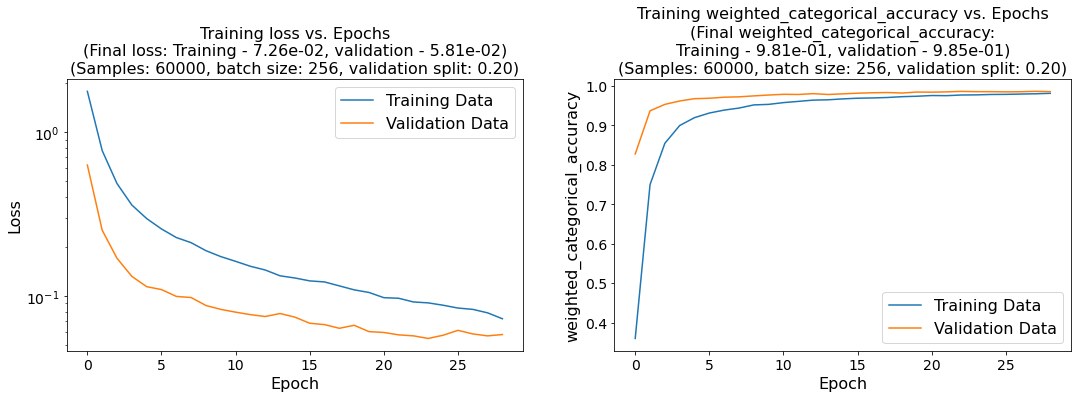

In [ ]:
# Training model
model_clf_og, train_history = train_model(
    model = model_clf_og,
    outputs_names = outputs_names,
    X_train = train_X_og,
    Y_train = train_y_ohe,

    train_model_flag = train_model_flag,
    save_model_flag = save_model_flag,
    load_model_flag = load_model_flag,
    model_path = model_path,

    training_epochs = training_epochs,
    training_batch_size = training_batch_size,
    training_validation_split = training_validation_split,
    training_targets_weights = training_targets_weights,
    training_verbose = training_verbose,
    training_callbacks = training_callbacks,
    
    show_model_summary = show_model_summary,
    plot_training_loss = plot_training_loss,
    plot_training_metric = plot_training_metric,
    plot_training_metric_names = plot_training_metric_names,
    plot_log_scale = plot_log_scale
    )

### Model - Classifying expanded images

In [ ]:
# Choosing training settings
train_model_flag = True
save_model_flag = True
load_model_flag = True
model_path = f'Models/model_clf_len_{image_len_expand}/'

outputs_names = ['output']
training_epochs = 50
training_batch_size = 256
training_validation_split = 0.2
training_targets_weights = training_targets_weights
training_verbose = 1
training_callbacks = EarlyStopping(monitor = 'val_loss', mode = 'min',
                                   restore_best_weights = True, patience = 5)

show_model_summary = False
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': 'CategoricalAccuracy'}
plot_training_metric_names = {'output': 'weighted_categorical_accuracy'}
plot_log_scale = True

In [ ]:
# Choosing model architecture
model_clf = Sequential([
    InputLayer(input_shape=(image_len_expand, image_len_expand, 1)),
    Conv2D(filters=8, kernel_size=6, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Conv2D(filters=32, kernel_size=4, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Flatten(),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(num_unique_targets, activation='softmax', name='output'),
])

model_clf.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.0003),
    metrics = training_metrics,
    weighted_metrics = training_metrics, # Metrics to weigh by sample_weight or class_weight
)

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50


C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 [==============================] - ETA: 0s - loss: 2.0878 - categorical_accuracy: 0.2269 - weighted_categorical_accuracy: 0.2232

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 [==============================] - 119s 634ms/step - loss: 2.0878 - categorical_accuracy: 0.2269 - weighted_categorical_accuracy: 0.2232 - val_loss: 1.2764 - val_categorical_accuracy: 0.6229 - val_weighted_categorical_accuracy: 0.6229
Epoch 2/50
188/188 [==============================] - 119s 631ms/step - loss: 1.2435 - categorical_accuracy: 0.5620 - weighted_categorical_accuracy: 0.5556 - val_loss: 0.6370 - val_categorical_accuracy: 0.8468 - val_weighted_categorical_accuracy: 0.8468
Epoch 3/50
188/188 [==============================] - 119s 633ms/step - loss: 0.8197 - categorical_accuracy: 0.7347 - weighted_categorical_accuracy: 0.7315 - val_loss: 0.3682 - val_categorical_accuracy: 0.9111 - val_weighted_categorical_accuracy: 0.9111
Epoch 4/50
188/188 [==============================] - 120s 640ms/step - loss: 0.5874 - categorical_accuracy: 0.8224 - weighted_categorical_accuracy: 0.8207 - val_loss: 0.2775 - val_categorical_accuracy: 0.9268 - val_weighted_categorical_accuracy: 0.

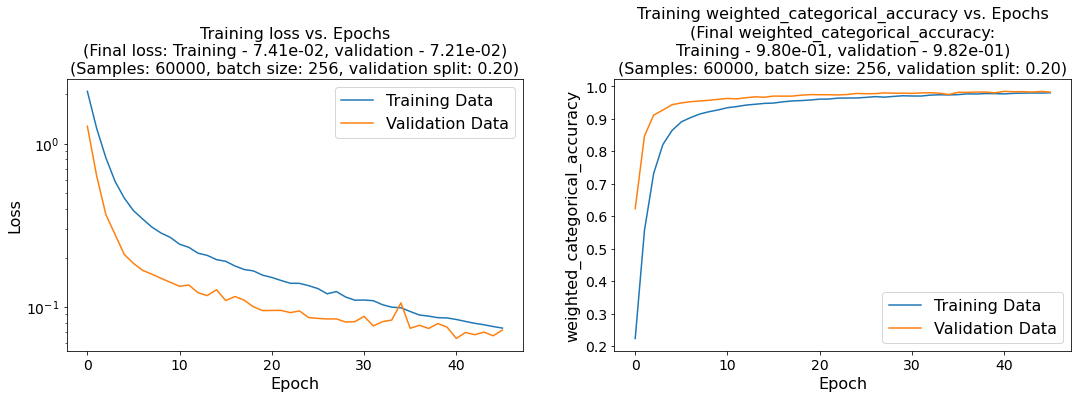

In [ ]:
# Training model
model_clf, train_history = train_model(
    model = model_clf,
    outputs_names = outputs_names,
    X_train = train_X,
    Y_train = train_y_ohe,

    train_model_flag = train_model_flag,
    save_model_flag = save_model_flag,
    load_model_flag = load_model_flag,
    model_path = model_path,

    training_epochs = training_epochs,
    training_batch_size = training_batch_size,
    training_validation_split = training_validation_split,
    training_targets_weights = training_targets_weights,
    training_verbose = training_verbose,
    training_callbacks = training_callbacks,
    
    show_model_summary = show_model_summary,
    plot_training_loss = plot_training_loss,
    plot_training_metric = plot_training_metric,
    plot_training_metric_names = plot_training_metric_names,
    plot_log_scale = plot_log_scale
    )

### Model - Localizing inside expanded images

In [ ]:
# Choosing training settings
train_model_flag = True
save_model_flag = True
load_model_flag = True
model_path = f'Models/model_loc_len_{image_len_expand}/'

outputs_names = ['output']
training_epochs = 50
training_batch_size = 256
training_validation_split = 0.2
training_targets_weights = None
training_verbose = 1
training_callbacks = EarlyStopping(monitor = 'val_loss', mode = 'min',
                                   restore_best_weights = True, patience = 5)

show_model_summary = False
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': 'mean_absolute_error'}
plot_training_metric_names = {'output': 'mean_absolute_error'}
plot_log_scale = True

In [ ]:
# Choosing model architecture
model_loc = Sequential([
    InputLayer(input_shape=(image_len_expand, image_len_expand, 1)),
    Conv2D(filters=8, kernel_size=6, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Conv2D(filters=32, kernel_size=4, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=2, padding='valid'),
    Flatten(),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(2, activation='relu', name='output'),
])

model_loc.compile(
    loss = 'mean_squared_error',
    optimizer = Adam(learning_rate=0.0003),
    metrics = training_metrics,
)

Epoch 1/50


C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 [==============================] - 119s 634ms/step - loss: 0.0594 - mean_absolute_error: 0.1940 - val_loss: 0.0119 - val_mean_absolute_error: 0.0950
Epoch 2/50
188/188 [==============================] - 119s 635ms/step - loss: 0.0237 - mean_absolute_error: 0.1208 - val_loss: 0.0032 - val_mean_absolute_error: 0.0482
Epoch 3/50
188/188 [==============================] - 118s 627ms/step - loss: 0.0172 - mean_absolute_error: 0.1029 - val_loss: 0.0021 - val_mean_absolute_error: 0.0385
Epoch 4/50
188/188 [==============================] - 117s 625ms/step - loss: 0.0142 - mean_absolute_error: 0.0930 - val_loss: 0.0016 - val_mean_absolute_error: 0.0336
Epoch 5/50
188/188 [==============================] - 117s 624ms/step - loss: 0.0118 - mean_absolute_error: 0.0846 - val_loss: 0.0017 - val_mean_absolute_error: 0.0355
Epoch 6/50
188/188 [==============================] - 117s 623ms/step - loss: 0.0103 - mean_absolute_error: 0.0788 - val_loss: 0.0012 - val_mean_absolute_error: 0.0289
Epo

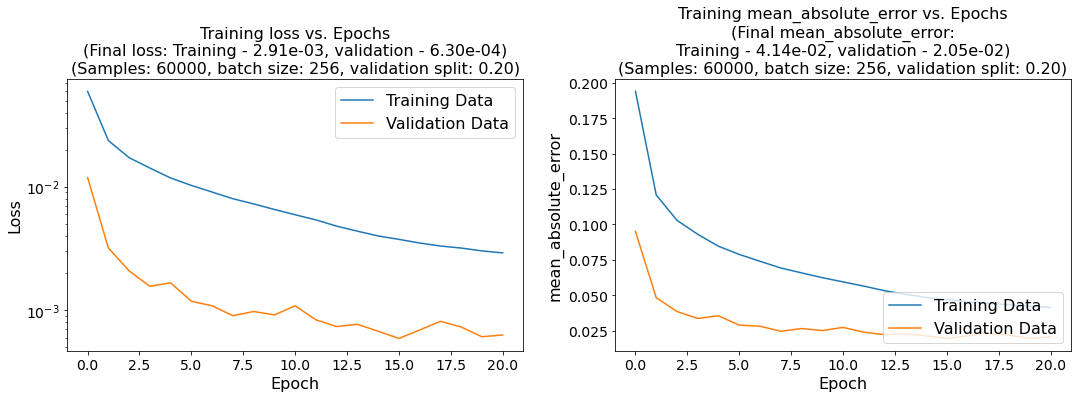

In [ ]:
# Training model
model_loc, train_history = train_model(
    model = model_loc,
    outputs_names = outputs_names,
    X_train = train_X,
    Y_train = train_loc,

    train_model_flag = train_model_flag,
    save_model_flag = save_model_flag,
    load_model_flag = load_model_flag,
    model_path = model_path,

    training_epochs = training_epochs,
    training_batch_size = training_batch_size,
    training_validation_split = training_validation_split,
    training_targets_weights = training_targets_weights,
    training_verbose = training_verbose,
    training_callbacks = training_callbacks,

    show_model_summary = show_model_summary,
    plot_training_loss = plot_training_loss,
    plot_training_metric = plot_training_metric,
    plot_training_metric_names = plot_training_metric_names,
    plot_log_scale = plot_log_scale
    )

### Model - Localizing and classifying together

In [ ]:
# Choosing training settings
train_model_flag = True
save_model_flag = True
load_model_flag = True
model_path = f'Models/model_loc_and_clf_len_{image_len_expand}/'

outputs_names = ['loc_branch','clf_branch']
training_epochs = 50
training_batch_size = 256
training_validation_split = 0.2
training_targets_weights = None
training_verbose = 1
training_callbacks = EarlyStopping(monitor = 'val_loss', mode = 'min',
                                   restore_best_weights = True, patience = 5)

show_model_summary = False
plot_training_loss = True
plot_training_metric = True
training_metrics = {'loc_branch': 'mean_absolute_error', 
                    'clf_branch': 'CategoricalAccuracy'}
plot_training_metric_names = {'loc_branch': 'mean_absolute_error', 
                              'clf_branch': 'categorical_accuracy'}
plot_log_scale = True

In [ ]:
# Choosing model architecture
summarize_arch = False

# Branch 1 - takes an expanded image as input and applies a CNN to it to extract features
model_input = Input(shape=(image_len_expand, image_len_expand, 1))
shared_branch = Conv2D(filters=8, kernel_size=6, activation='relu', padding='same')(model_input)
shared_branch = MaxPooling2D(pool_size=2, padding='valid')(shared_branch)
shared_branch = Conv2D(filters=16, kernel_size=5, activation='relu', padding='same')(shared_branch)
shared_branch = MaxPooling2D(pool_size=2, padding='valid')(shared_branch)
shared_branch = Conv2D(filters=32, kernel_size=4, activation='relu', padding='same')(shared_branch)
shared_branch = MaxPooling2D(pool_size=2, padding='valid')(shared_branch)
shared_branch = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(shared_branch)
shared_branch = MaxPooling2D(pool_size=2, padding='valid')(shared_branch)
shared_branch = Flatten()(shared_branch)

# Branch 2 - localization head - predicts the location coordinates (x,y) of the digit
loc_branch = Dense(32, activation='relu')(shared_branch)
loc_branch = Dropout(0.25)(loc_branch)
loc_branch = Dense(32, activation='relu')(loc_branch)
loc_branch = Dropout(0.25)(loc_branch)
loc_branch = Dense(16, activation='relu')(loc_branch)
loc_branch = Dropout(0.25)(loc_branch)
loc_branch = Dense(2, activation='relu', name='loc_branch')(loc_branch)

# Branch 3 - classification head - predicts the one-hot encoded class of the digit
clf_branch = Dense(32, activation='relu')(shared_branch)
clf_branch = Dropout(0.25)(clf_branch)
clf_branch = Dense(32, activation='relu')(clf_branch)
clf_branch = Dropout(0.25)(clf_branch)
clf_branch = Dense(16, activation='relu')(clf_branch)
clf_branch = Dropout(0.25)(clf_branch)
clf_branch = Dense(num_unique_targets, activation='softmax', name='clf_branch')(clf_branch)

# Defining the overall model
model_loc_and_clf = Model(inputs=model_input, outputs=[loc_branch, clf_branch])

if summarize_arch:
    model_loc_and_clf.summary(show_trainable=True)
    print('\n\n\n')
if not is_runtime_local:
    plot_model(model_loc_and_clf,
               to_file = model_path + 'model_loc_and_clf.png',
               show_shapes = True,
               expand_nested = True,
               show_layer_activations = True)

model_loc_and_clf.compile(
    loss = {'loc_branch':'mean_squared_error',
            'clf_branch': 'categorical_crossentropy'},
    optimizer = Adam(learning_rate=0.0003),
    metrics = training_metrics,
    weighted_metrics = training_metrics, # Metrics to weigh by sample_weight or class_weight
)

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50


C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 [==============================] - ETA: 0s - loss: 2.3090 - loc_branch_loss: 0.0770 - clf_branch_loss: 2.2320 - loc_branch_mean_absolute_error: 0.2215 - loc_branch_weighted_mean_absolute_error: 0.2215 - clf_branch_categorical_accuracy: 0.1594 - clf_branch_weighted_categorical_accuracy: 0.1594

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 [==============================] - 120s 639ms/step - loss: 2.3090 - loc_branch_loss: 0.0770 - clf_branch_loss: 2.2320 - loc_branch_mean_absolute_error: 0.2215 - loc_branch_weighted_mean_absolute_error: 0.2215 - clf_branch_categorical_accuracy: 0.1594 - clf_branch_weighted_categorical_accuracy: 0.1594 - val_loss: 1.9215 - val_loc_branch_loss: 0.0168 - val_clf_branch_loss: 1.9047 - val_loc_branch_mean_absolute_error: 0.1115 - val_loc_branch_weighted_mean_absolute_error: 0.1115 - val_clf_branch_categorical_accuracy: 0.3256 - val_clf_branch_weighted_categorical_accuracy: 0.3256
Epoch 2/50
188/188 [==============================] - 120s 636ms/step - loss: 1.7575 - loc_branch_loss: 0.0304 - clf_branch_loss: 1.7272 - loc_branch_mean_absolute_error: 0.1375 - loc_branch_weighted_mean_absolute_error: 0.1375 - clf_branch_categorical_accuracy: 0.3519 - clf_branch_weighted_categorical_accuracy: 0.3519 - val_loss: 1.2415 - val_loc_branch_loss: 0.0107 - val_clf_branch_loss: 1.2307 - val_loc_b

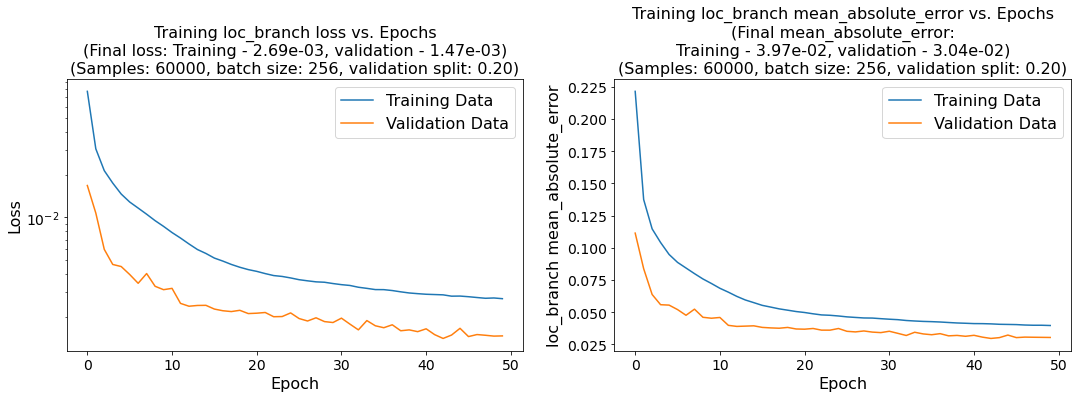


Final clf_branch loss - Training: 1.491e-01, validation: 1.177e-01
Final clf_branch categorical_accuracy - Training: 95.76%, validation: 97.53%



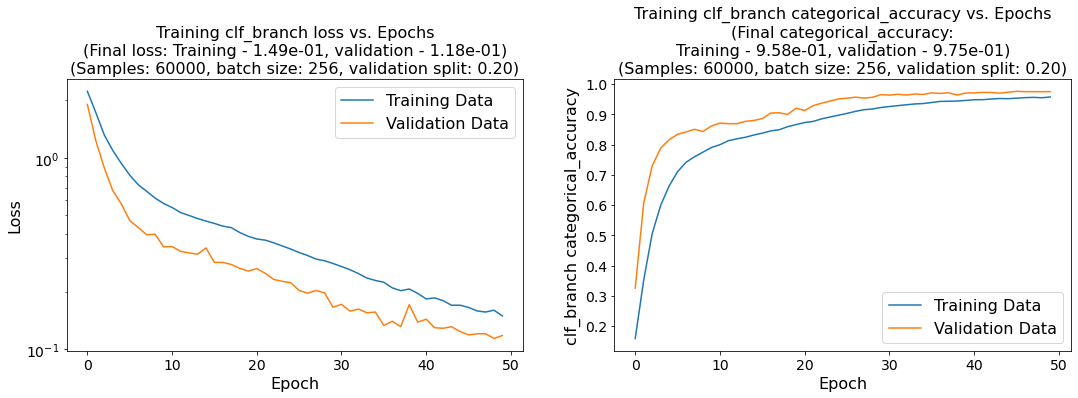

In [ ]:
# Training model
model_loc_and_clf, train_history = train_model(
    model = model_loc_and_clf,
    outputs_names = outputs_names,
    X_train = train_X,
    Y_train = {'loc_branch': train_loc,
               'clf_branch': train_y_ohe},
    train_model_flag = train_model_flag,
    save_model_flag = save_model_flag,
    load_model_flag = load_model_flag,
    model_path = model_path,

    training_epochs = training_epochs,
    training_batch_size = training_batch_size,
    training_validation_split = training_validation_split,
    training_targets_weights = training_targets_weights,
    training_verbose = training_verbose,
    training_callbacks = training_callbacks,
    
    show_model_summary = show_model_summary,
    plot_training_loss = plot_training_loss,
    plot_training_metric = plot_training_metric,
    plot_training_metric_names = plot_training_metric_names,
    plot_log_scale = plot_log_scale
    )

### Model - Localizing and then classifying

In [ ]:
# Choosing training settings
train_model_flag = True
save_model_flag = True
load_model_flag = True
model_path = f'Models/model_clf_after_loc_len_{image_len_expand}/'

outputs_names = ['output']
training_epochs = 50
training_batch_size = 256
training_validation_split = 0.2
training_targets_weights = training_targets_weights
training_verbose = 1
training_callbacks = EarlyStopping(monitor = 'val_loss', mode = 'min',
                                   restore_best_weights = True, patience = 5)

show_model_summary = False
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': 'CategoricalAccuracy'}
plot_training_metric_names = {'output': 'weighted_categorical_accuracy'}
plot_log_scale = True

In [ ]:
# Choosing model architecture
summarize_arch = False

# The shared input of the following 2 branches
model_input = Input(shape=(image_len_expand, image_len_expand, 1))


# Branch 1 - takes an expanded image as input and applies a standard CNN to it
branch_1 = Conv2D(filters=8, kernel_size=6, activation='relu', padding='same')(model_input)
branch_1 = MaxPooling2D(pool_size=2, padding='valid')(branch_1)
branch_1 = Conv2D(filters=16, kernel_size=5, activation='relu', padding='same')(branch_1)
branch_1 = MaxPooling2D(pool_size=2, padding='valid')(branch_1)
branch_1 = Conv2D(filters=32, kernel_size=4, activation='relu', padding='same')(branch_1)
branch_1 = MaxPooling2D(pool_size=2, padding='valid')(branch_1)
branch_1 = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(branch_1)
branch_1 = MaxPooling2D(pool_size=2, padding='valid')(branch_1)
branch_1 = Flatten()(branch_1)
branch_1 = Model(inputs=model_input, outputs=branch_1)

if summarize_arch:
    branch_1.summary(show_trainable=True)
    print('\n\n\n')


# Branch 2 - the pretrained localization model,
# which takes an expanded image and predicts the digit location coordinates (x,y)
model_loc.trainable = False # Freezing the localization model
branch_2 = model_loc(model_input)
branch_2 = Model(inputs=model_input, outputs=branch_2)

if summarize_arch:
    branch_2.summary(show_trainable=True)
    print('\n\n\n')


# Branch 3 - takes as input the combined 2 input branches
combined_output = concatenate([branch_1.output, branch_2.output])
branch_3 = Dense(32, activation='relu')(combined_output)
branch_3 = Dropout(0.25)(branch_3)
branch_3 = Dense(32, activation='relu')(branch_3)
branch_3 = Dropout(0.25)(branch_3)
branch_3 = Dense(num_unique_targets, activation='softmax', name='output')(branch_3)


# Defining the overall model
model_clf_after_loc = Model(inputs=model_input, outputs=branch_3)

if summarize_arch:
    model_clf_after_loc.summary(show_trainable=True)
    print('\n\n\n')
if not is_runtime_local:
    plot_model(model_clf_after_loc,
               to_file = model_path + 'model_clf_after_loc.png',
               show_shapes = True,
               expand_nested = True,
               show_layer_activations = True)

model_clf_after_loc.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.0003),
    metrics = training_metrics,
    weighted_metrics = training_metrics, # Metrics to weigh by sample_weight or class_weight
)

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50


C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 [==============================] - ETA: 0s - loss: 2.0476 - categorical_accuracy: 0.2315 - weighted_categorical_accuracy: 0.2315

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


188/188 [==============================] - 235s 1s/step - loss: 2.0476 - categorical_accuracy: 0.2315 - weighted_categorical_accuracy: 0.2315 - val_loss: 1.2163 - val_categorical_accuracy: 0.6504 - val_weighted_categorical_accuracy: 0.6504
Epoch 2/50
188/188 [==============================] - 234s 1s/step - loss: 1.1817 - categorical_accuracy: 0.5770 - weighted_categorical_accuracy: 0.5770 - val_loss: 0.5942 - val_categorical_accuracy: 0.8489 - val_weighted_categorical_accuracy: 0.8489
Epoch 3/50
188/188 [==============================] - 234s 1s/step - loss: 0.7921 - categorical_accuracy: 0.7346 - weighted_categorical_accuracy: 0.7346 - val_loss: 0.3562 - val_categorical_accuracy: 0.9055 - val_weighted_categorical_accuracy: 0.9055
Epoch 4/50
188/188 [==============================] - 234s 1s/step - loss: 0.5933 - categorical_accuracy: 0.8098 - weighted_categorical_accuracy: 0.8098 - val_loss: 0.2656 - val_categorical_accuracy: 0.9260 - val_weighted_categorical_accuracy: 0.9260
Epoch 5

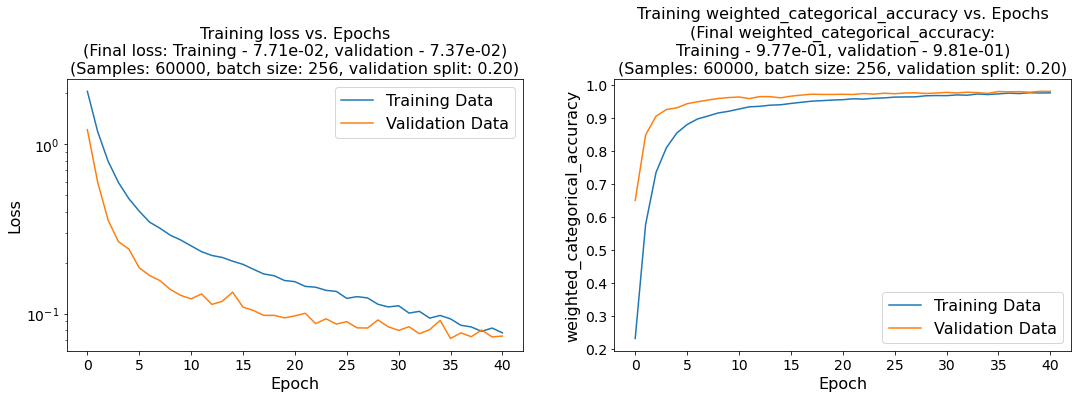

In [ ]:
# Training model
model_clf_after_loc, train_history = train_model(
    model = model_clf_after_loc,
    outputs_names = outputs_names,
    X_train = train_X,
    Y_train = train_y_ohe,

    train_model_flag = train_model_flag,
    save_model_flag = save_model_flag,
    load_model_flag = load_model_flag,
    model_path = model_path,

    training_epochs = training_epochs,
    training_batch_size = training_batch_size,
    training_validation_split = training_validation_split,
    training_targets_weights = training_targets_weights,
    training_verbose = training_verbose,
    training_callbacks = training_callbacks,
    
    show_model_summary = show_model_summary,
    plot_training_loss = plot_training_loss,
    plot_training_metric = plot_training_metric,
    plot_training_metric_names = plot_training_metric_names,
    plot_log_scale = plot_log_scale
    )

# 3) Evaluating model

## a. Evaluation function

In [ ]:
def evaluate_model(model, test_X, test_y, show_eval):
    ''' Evaluates the performance of a model on test data,
    and return the evaluation metrics names and values. '''
    
    eval_metrics_names = model.metrics_names
    eval_metrics = model.evaluate(x = test_X, y = test_y, verbose=1)
    print()
    eval_metrics = [round(x, 4) for x in eval_metrics]

    if show_eval:
        print('Presenting evaluation metrics:\n')
        for i in range(0,len(eval_metrics_names)):
            print(f'{eval_metrics_names[i]}: {eval_metrics[i]}')

    return eval_metrics_names, eval_metrics

In [ ]:
# Evaluating the "localizing and classifying together" model on the test data
if evaluate_model_flag:
    eval_metrics_names, eval_metrics = \
        evaluate_model(model = model_loc_and_clf,
                       test_X = test_X,
                       test_y = {'loc_branch': test_loc,
                                 'clf_branch': test_y_ohe},
                       show_eval = True)

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


  3/313 [..............................] - ETA: 11s - loss: 0.0172 - loc_branch_loss: 0.0016 - clf_branch_loss: 0.0157 - loc_branch_mean_absolute_error: 0.0312 - loc_branch_weighted_mean_absolute_error: 0.0312 - clf_branch_categorical_accuracy: 1.0000 - clf_branch_weighted_categorical_accuracy: 1.0000

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 11s 36ms/step - loss: 0.0936 - loc_branch_loss: 0.0014 - clf_branch_loss: 0.0922 - loc_branch_mean_absolute_error: 0.0295 - loc_branch_weighted_mean_absolute_error: 0.0295 - clf_branch_categorical_accuracy: 0.9804 - clf_branch_weighted_categorical_accuracy: 0.9804

Presenting evaluation metrics:

loss: 0.0936
loc_branch_loss: 0.0014
clf_branch_loss: 0.0922
loc_branch_mean_absolute_error: 0.0295
loc_branch_weighted_mean_absolute_error: 0.0295
clf_branch_categorical_accuracy: 0.9804
clf_branch_weighted_categorical_accuracy: 0.9804


In [ ]:
# Evaluating the "classifying after localizing" model on the test data
if evaluate_model_flag:
    eval_metrics_names, eval_metrics = \
        evaluate_model(model = model_clf_after_loc,
                       test_X = test_X,
                       test_y = {'output': test_y_ohe},
                       show_eval = True)

  2/313 [..............................] - ETA: 21s - loss: 0.0391 - categorical_accuracy: 0.9844 - weighted_categorical_accuracy: 0.9844

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 18s 56ms/step - loss: 0.0667 - categorical_accuracy: 0.9811 - weighted_categorical_accuracy: 0.9811

Presenting evaluation metrics:

loss: 0.0667
categorical_accuracy: 0.9811
weighted_categorical_accuracy: 0.9811


The model evaluation function evaluates the performance of a neural network based on the tasks it performs, by calculating an appropriate evluation metric for each one:
- For the localization problem, which is a regression problem, the mean absolute error is used as the metric of choice, to evaluate the erroneous distance between the true and predicted location of the digit.
- For the digit classification problem, the classification accuracy by category is calculated, for a one-hot encoded category.

To do so, the function recieves:
- A model whose performance we wish to evaluate.
- Test features (test_X) which we wish to evaluate the performance on.
- A set of the corresponding true test targets (test_y), whose number depends on the number of model outputs we wish to evaluate. The latter can be the locations of the digits to evaluate the localization prediction, and a set of the true digit categories to evaluate the classification.

## b. Evaluation with noise function

In [ ]:
# Defining enumerations for noise types
class NoiseType(enum.Enum):
    GaussianNoise = 1
    SaltAndPepper = 2
    Rotation = 3
    Brightness = 4
    Darkness = 5

In [ ]:
def add_noises(images, noise_types, plot_noises):
    ''' Adds the selected noise types to an input set of images. '''

    # Initializing variables
    noisy_images = copy.deepcopy(images) # Copying the images for later comparison
    noisy_images = noisy_images.astype(np.uint8) # Limiting values to [0,255]
    noisy_images = np.expand_dims(noisy_images, -1) # Setting 1 channel
    images_num = noisy_images.shape[0]

    # Applying noises
    # Gaussian noise
    if NoiseType.GaussianNoise in noise_types:
        noise = np.zeros_like(noisy_images, dtype=np.uint8) # The noise we'll add
        cv2.randn(noise, 0, 20) # Fills array with normally distributed numbers
        noise = noise.astype(np.uint8)
        noisy_images = cv2.add(noisy_images, noise) # Adding the noise to the images

    # Salt & pepper noise
    if NoiseType.SaltAndPepper in noise_types:
        noise = np.zeros_like(noisy_images, dtype=np.uint8) # The noise we'll add
        cv2.randu(noise, 0, 255) # Fills array with uniformly distributed numbers
        for i in range(0,noise.shape[0]):
            # Keeping the maximal value when above a threshold
            noise[i] = np.expand_dims(cv2.threshold(noise[i], thresh=250, maxval=255, type=cv2.THRESH_BINARY)[1], -1)
        noisy_images = cv2.add(noisy_images, noise) # Adding the noise to the images

    # Rotation
    if NoiseType.Rotation in noise_types:
        for i in range(0,images_num):
            # Supports ROTATE_90_CLOCKWISE, ROTATE_180, ROTATE_90_COUNTERCLOCKWISE
            noisy_images[i] = np.expand_dims(cv2.rotate(noisy_images[i], cv2.ROTATE_90_COUNTERCLOCKWISE), -1)

    if NoiseType.Brightness in noise_types:
        noisy_images = noisy_images.astype(np.uint16) # Allows passing 255
        for i in range(0,images_num):
            noisy_images[i] = noisy_images[i] + random.randint(0, 50) # Increasing brightness
            noisy_images[i][noisy_images[i] > 255] = 255 # Keeping max value at 255
        noisy_images = noisy_images.astype(np.uint8)

    if NoiseType.Darkness in noise_types:
        noisy_images = noisy_images.astype(np.int16) # Allows passing 255
        for i in range(0,images_num):
            noisy_images[i] = noisy_images[i] - random.randint(0, 50) # Increasing darkness
            noisy_images[i][noisy_images[i] < 0] = 0 # Keeping min value at 0
        noisy_images = noisy_images.astype(np.uint8)

    # Plotting an example image before and after the application of noises
    if plot_noises:
        i = 0
        compare_images(image_1 = images[i], title_1 = 'Original image',
                       image_2 = noisy_images[i], title_2 = 'Noisy image')
        
    return noisy_images

I have chosen these noise types for the exploration by considering which noises could appear in a digit classification problem realistically. Assuming the images are taken by a camera after a human has written them on a paper, the following issues may arise:
- Gaussian noise, or 'electronic' noise - Can arise in detectors, and originates from the random thermal motion of charge carriers in conductors.
- "Salt and pepper" noise - Can appear due to issues with the conversion of analog signals to digital signals, in particular faulty electronic components, or from a bad transmission. When these disturbances are sharp, pixels obtain the extreme values of 0 or 255. This nosie can additionally simulate the appearance of dirt on the paper or dust on the camera lens.
- Rotation - The person may draw the digit at an angle, due to his handwritting or by mistake, or the paper and camera may be rotated relative to each other before the image is taken.
- Brightness and darkness - The image may be photographed in different lighting conditions, or the digit might be drawn on different colored papers, or even with different colored ink, which would translate to a brighter or darker background in relation to the digit.

In [ ]:
def evaluate_model_with_noise(
    model, test_X_unprocessed, show_eval, test_y, noise_types_dict, plot_noises):
    ''' Evaluate the performance of a model on a set of images on two tasks - 
    localization and classfication - after applying different noises to them. '''

    # Initializaing dataframe for collecting results
    eval_metrics_with_noises = \
        pd.DataFrame(columns = ['noise_id', 'eval_metrics_names', 'eval_metrics'])

    # Going over different noise types
    for noise_id, noise_types in noise_types_dict.items():
        print(f'Evaluating performance for {noise_id}:\n')

        # Applying noises
        test_X_noisy = add_noises(images = test_X_unprocessed, 
                                  noise_types = noise_types,
                                  plot_noises = plot_noises)
        
        # Evaluating model
        eval_metrics_names, eval_metrics = \
            evaluate_model(model = model_loc_and_clf,
                           test_X = test_X_noisy,
                           test_y = test_y,
                           show_eval = show_eval)
        
        # Collecting results
        new_row = pd.DataFrame({'noise_id': noise_id,
                                'eval_metrics_names': eval_metrics_names,
                                'eval_metrics': eval_metrics})
        eval_metrics_with_noises = pd.concat([eval_metrics_with_noises, new_row])
        print('\n################################################################################\n')
    
    # Presenting results
    print('Presenting performance evaluation results:\n')
    print(eval_metrics_with_noises)

    return eval_metrics_with_noises

Evaluating performance for gaussian noise:



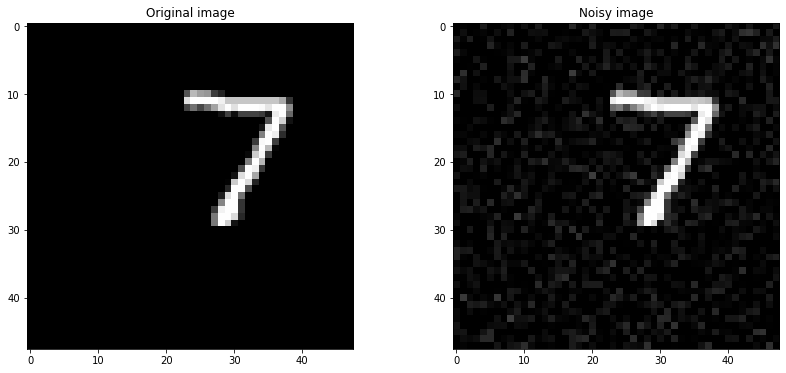


  3/313 [..............................] - ETA: 11s - loss: 120.5173 - loc_branch_loss: 96.9238 - clf_branch_loss: 23.5935 - loc_branch_mean_absolute_error: 6.5485 - loc_branch_weighted_mean_absolute_error: 6.5485 - clf_branch_categorical_accuracy: 0.9583 - clf_branch_weighted_categorical_accuracy: 0.9583    

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 11s 36ms/step - loss: 152.7209 - loc_branch_loss: 115.7997 - clf_branch_loss: 36.9213 - loc_branch_mean_absolute_error: 7.2080 - loc_branch_weighted_mean_absolute_error: 7.2080 - clf_branch_categorical_accuracy: 0.9454 - clf_branch_weighted_categorical_accuracy: 0.9454


################################################################################

Evaluating performance for salt & pepper noise:



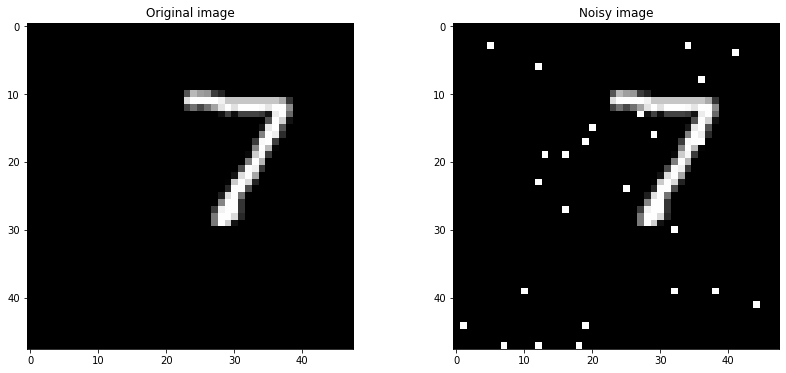


  3/313 [..............................] - ETA: 10s - loss: 225.5962 - loc_branch_loss: 87.7630 - clf_branch_loss: 137.8332 - loc_branch_mean_absolute_error: 6.1813 - loc_branch_weighted_mean_absolute_error: 6.1813 - clf_branch_categorical_accuracy: 0.8438 - clf_branch_weighted_categorical_accuracy: 0.8438

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 11s 36ms/step - loss: 206.5746 - loc_branch_loss: 99.1837 - clf_branch_loss: 107.3909 - loc_branch_mean_absolute_error: 6.7407 - loc_branch_weighted_mean_absolute_error: 6.7407 - clf_branch_categorical_accuracy: 0.8481 - clf_branch_weighted_categorical_accuracy: 0.8481


################################################################################

Evaluating performance for rotation:



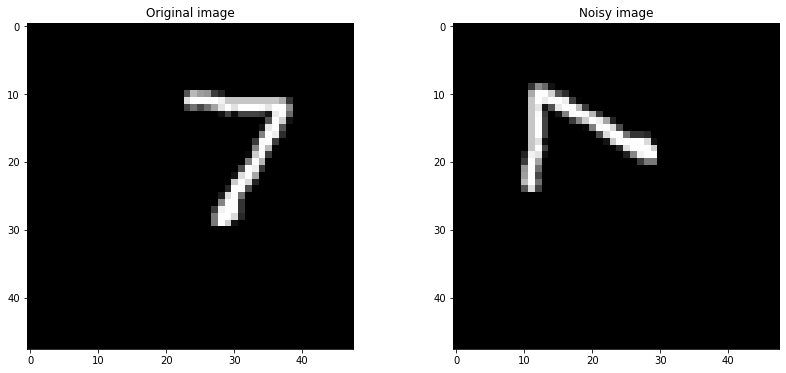


  3/313 [..............................] - ETA: 11s - loss: 1856.7490 - loc_branch_loss: 77.3097 - clf_branch_loss: 1779.4395 - loc_branch_mean_absolute_error: 5.5831 - loc_branch_weighted_mean_absolute_error: 5.5831 - clf_branch_categorical_accuracy: 0.1875 - clf_branch_weighted_categorical_accuracy: 0.1875

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 11s 36ms/step - loss: 1797.8405 - loc_branch_loss: 87.2551 - clf_branch_loss: 1710.5846 - loc_branch_mean_absolute_error: 6.0615 - loc_branch_weighted_mean_absolute_error: 6.0615 - clf_branch_categorical_accuracy: 0.1622 - clf_branch_weighted_categorical_accuracy: 0.1622


################################################################################

Evaluating performance for brightness:



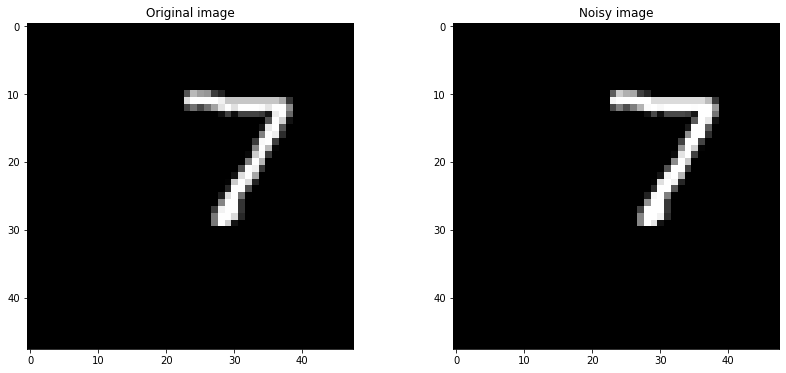


  3/313 [..............................] - ETA: 10s - loss: 232.2685 - loc_branch_loss: 70.8547 - clf_branch_loss: 161.4138 - loc_branch_mean_absolute_error: 5.5314 - loc_branch_weighted_mean_absolute_error: 5.5314 - clf_branch_categorical_accuracy: 0.8021 - clf_branch_weighted_categorical_accuracy: 0.8021

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 11s 36ms/step - loss: 259.6165 - loc_branch_loss: 81.7450 - clf_branch_loss: 177.8715 - loc_branch_mean_absolute_error: 5.9730 - loc_branch_weighted_mean_absolute_error: 5.9730 - clf_branch_categorical_accuracy: 0.7955 - clf_branch_weighted_categorical_accuracy: 0.7955


################################################################################

Evaluating performance for darkness:



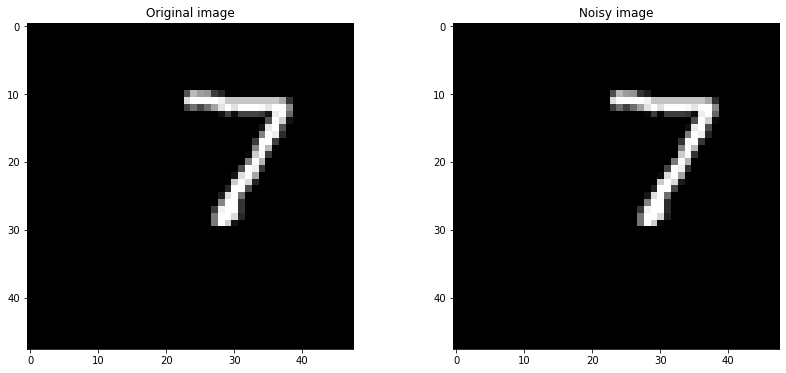


  3/313 [..............................] - ETA: 9s - loss: 105.4588 - loc_branch_loss: 88.5451 - clf_branch_loss: 16.9138 - loc_branch_mean_absolute_error: 6.1721 - loc_branch_weighted_mean_absolute_error: 6.1721 - clf_branch_categorical_accuracy: 0.9479 - clf_branch_weighted_categorical_accuracy: 0.9479

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 11s 36ms/step - loss: 136.7324 - loc_branch_loss: 105.0225 - clf_branch_loss: 31.7099 - loc_branch_mean_absolute_error: 6.7910 - loc_branch_weighted_mean_absolute_error: 6.7910 - clf_branch_categorical_accuracy: 0.9529 - clf_branch_weighted_categorical_accuracy: 0.9529


################################################################################

Evaluating performance for gaussian and s&p noises:



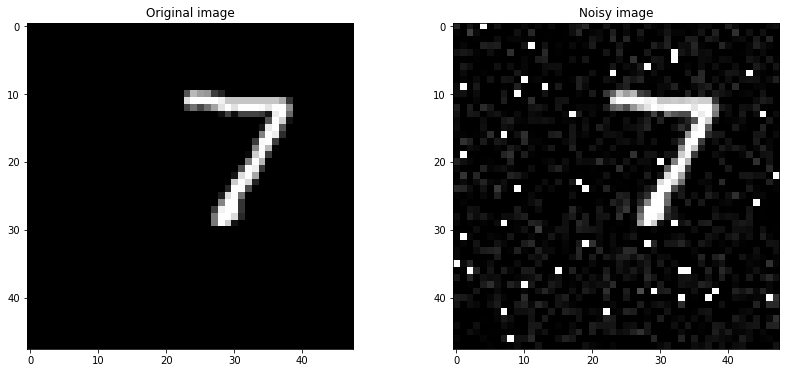


  3/313 [..............................] - ETA: 11s - loss: 183.8795 - loc_branch_loss: 78.5969 - clf_branch_loss: 105.2826 - loc_branch_mean_absolute_error: 6.0412 - loc_branch_weighted_mean_absolute_error: 6.0412 - clf_branch_categorical_accuracy: 0.8229 - clf_branch_weighted_categorical_accuracy: 0.8229

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 11s 36ms/step - loss: 263.0634 - loc_branch_loss: 92.8828 - clf_branch_loss: 170.1806 - loc_branch_mean_absolute_error: 6.5820 - loc_branch_weighted_mean_absolute_error: 6.5820 - clf_branch_categorical_accuracy: 0.7944 - clf_branch_weighted_categorical_accuracy: 0.7944


################################################################################

Evaluating performance for all noises:



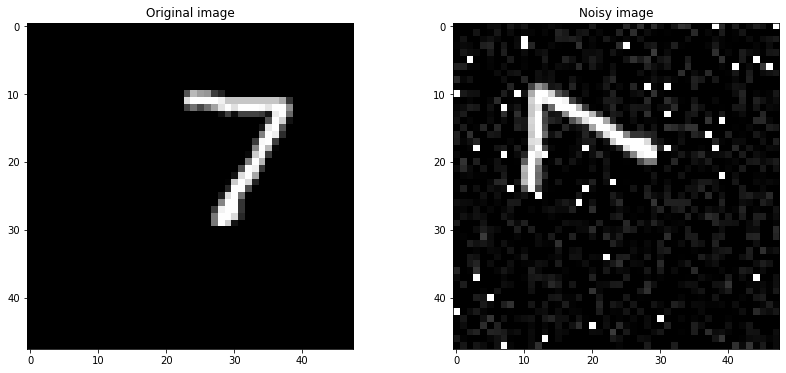


  4/313 [..............................] - ETA: 11s - loss: 1482.4094 - loc_branch_loss: 45.5788 - clf_branch_loss: 1436.8308 - loc_branch_mean_absolute_error: 4.5817 - loc_branch_weighted_mean_absolute_error: 4.5817 - clf_branch_categorical_accuracy: 0.1719 - clf_branch_weighted_categorical_accuracy: 0.1719

C:\Users\Sergey\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 11s 36ms/step - loss: 1298.6970 - loc_branch_loss: 52.6621 - clf_branch_loss: 1246.0345 - loc_branch_mean_absolute_error: 4.9609 - loc_branch_weighted_mean_absolute_error: 4.9609 - clf_branch_categorical_accuracy: 0.1464 - clf_branch_weighted_categorical_accuracy: 0.1464


################################################################################

Presenting performance evaluation results:

                  noise_id                        eval_metrics_names  eval_metrics
0           gaussian noise                                      loss      152.7209
1           gaussian noise                           loc_branch_loss      115.7997
2           gaussian noise                           clf_branch_loss       36.9213
3           gaussian noise            loc_branch_mean_absolute_error        7.2080
4           gaussian noise   loc_branch_weighted_mean_absolute_error        7.2080
5           gaussian noise           clf_branch_categorical

In [ ]:
# Evaluating model for different noises
eval_metrics_with_noises = \
    evaluate_model_with_noise(
        model = model_loc_and_clf,
        test_X_unprocessed = test_X_unprocessed,
        test_y = {'loc_branch': test_loc,
                  'clf_branch': test_y_ohe},
        show_eval = False,

        noise_types_dict = {
            'gaussian noise': [NoiseType.GaussianNoise],
            'salt & pepper noise': [NoiseType.SaltAndPepper],
            'rotation': [NoiseType.Rotation],
            'brightness': [NoiseType.Brightness],
            'darkness': [NoiseType.Darkness],
            'gaussian and s&p noises': [NoiseType.GaussianNoise, NoiseType.SaltAndPepper],
            'all noises': [NoiseType.GaussianNoise, NoiseType.SaltAndPepper,
                           NoiseType.Rotation, NoiseType.Brightness, NoiseType.Darkness],
            },
        plot_noises = True    
        )

In [ ]:
# Filtering & sorting results
metrics_to_explore = ['loc_branch_mean_absolute_error',
                      'clf_branch_weighted_categorical_accuracy']
for metric_to_explore in metrics_to_explore:
    print(f'Exploring the {metric_to_explore} metric:\n')
    print(eval_metrics_with_noises.query('eval_metrics_names == @metric_to_explore') \
          .sort_values('eval_metrics')[['noise_id','eval_metrics']], '\n')

Exploring the loc_branch_mean_absolute_error metric:

                  noise_id  eval_metrics
3               all noises        4.9609
3               brightness        5.9730
3                 rotation        6.0615
3  gaussian and s&p noises        6.5820
3      salt & pepper noise        6.7407
3                 darkness        6.7910
3           gaussian noise        7.2080 

Exploring the clf_branch_weighted_categorical_accuracy metric:

                  noise_id  eval_metrics
6               all noises        0.1464
6                 rotation        0.1622
6  gaussian and s&p noises        0.7944
6               brightness        0.7955
6      salt & pepper noise        0.8481
6           gaussian noise        0.9454
6                 darkness        0.9529 



I have learned the following about the impact of the different noises on the performance of the model. I note that this part of the research requires a much deeper study, especially since there are many parameters to play with for each noise type, and it is important to match the noise levels to realistic ones, plus some combinations of noise types may make it significantly easier or harder for the model to work.

For the specific parameters I've experimented with, classfication was less effected than localization, which can be attributed to the noises not completely ruining the features of the digits. This allows the convolutional filters to still detect them well enough. Localization, on the other hand, was learned based on a certain brightness ratio and pixel density in some area, and the noises I applied directly change these two. 

The noise types which ruined the localization capability the most in descending order are the Gaussian noise, followed closely by darkness, salt & pepper noise, and the combination of Guassian and S&P. As mentioned, this reflects exactly the disruptive nature of changing the pixel densities on the localization (the Guassian effect is denser than S&P for example), followed by changing their brightness. The appearance of the combination of noises in the last place can be attributed to how brightness and darkness can cancel each other, and bring the values of noisy and non-noisy pixels closer to each other.

The noise types which ruined the classification capability the most in descending order are:
- The combinations of the noises, which is expected since they don't cancel each other here, but more importatnly, they include rotation (see next bullet).
- Rotation, which makes sense since the digits aren't rotationally invariant, the rotation was relatively extreme (90 degrees), and rotating a digit is like effectively creating a new one.

For the rest of the noises we see a noticable improvement in the class prediction relative to rotation, and can notice that the S&P noise is more disruptive than the Gaussian noise, which makes sense since it's much less uniform.

## c. Improvement suggestions

To push the performance of the network even further, and especially improve its tolerance towards different noise types, the following can be done:
- Add noisy data to the training set, prioritizing adding data with the noise types for which the model struggles the most. E.g. it's very simple to augment our dataset with multiple versions of brightness levels per image to improve our suffering localization. This is useful since our model never learned what noise looks like.
- Add data preprocessing before the prediction, especially denoising techniqes which are appropriate for the problematic noise types. E.g. Gaussian noise can be diminished via a non-local means algorithm and median blur can be used for S&P noise. This is useful since it makes the data for predicting more similar to the data our model has seen during training.
- Add algorithmics to assist the prediction. E.g. to address rotation, try predicting for multiple rotation angles when the classification probability is low (no single class obtains a high probability at the softmax layer), and select the prediction for the angle with the highest probability classification as the winner. Algorithmics are useful as they can supplement the model, by adding logic that the model might have not figured out during training.
- Improve the architecture and hyperparameters, by experimenting and comparing more designs, and by performing an automated hyperparameter grid-search. This is useful since it's a direct method to raise the performance.
- Use better models in general. In particular, perform a literature review, use pretrained models which learned to tackle our noises, and even combine different ones, or e.g. apply a sliding windows detection model, which may help by zooming into an area and thus ignoring distractions. Using better models is useful since it can save significant amounts of research time, training time and money.

# 4) Deploying model

## a. Designing front-end 

A possible implementation for the front-end could be a friendly user interface in a designated **web application**.

Let's assume the images are taken by some camera or detector on some user-operated device (as opposed to taking the photos automatically), which is a common use case when scanning a textual document. Before the user interacts with the front-end, the image is therefore first saved locally on the device of the user.

Depending on how we implement the back-end, the user will need to either upload the photos to our servers through the app for analysis, or to upload them to some hosting service and input their URL into the app. Let's implement the latter option.

The user will enter the web app by inputting its URL in his browser, where he will be presented with the following elements, for example:
- A URL input field, to input the URL of his uploaded photo, or a batch of URLs, and a confirm button.
- A list of the available photo URLs with tick boxes next to them, to select for which photos to predict the location and class of the digit.
- A "view photos" button, to view the selected photos.
- A "predict" button, which after it was pressed a progress bar can be shown for the duration of the predicting calculation.
- A "help" button, for presenting instructions and tips about how to ideally take photos such that the DL model will give the best results.

## b. Designing back-end 

The back-end for the web app can be implemented via a web app creation framework, where simple options can be Flask or Streamlit.

- First, the trained model will be saved on a local or virtual machine, e.g. by serializing it with the pickle module, or by ONNX, which is a great choice. In addition, we save any preprocessing parameters (e.g. scaling constants) and the names of the encoded targets. 

- Next, we write a python code which (1) carries out the prediction pipeline and (2) specifies the design of the web page that the user interacts with, as described in the previous question.

- The prediction pipeline is as follows:
1. Load the serialized model from the machine (with a regular load_model()), preferably one time to a cache. In addition, load the preprocessing parameters and the names of the encoded targets.
2. Load the image from the user's URL with a get request (requests.get()).
3. Preprocess the image to be compatible to the model: decode the image to have 1 channel, convert the data type to float to perform the scaling, scale the image into [0,1], resize them (tf.image.resize), and add a dimension for batch size.
4. Predict with the model (model.predict()) and convert the predictions to an interpretable form - scale the location coordinates back up, and for the classification, choose the class with the highest probability and decode it to its original target name.
5. Present on the web page the predicted location coordinate (x,y) and the class (0-9) of the digit.

- The code will run on the machine (streamlit run file_name.py) and the app will communicate on a certain local port.

- The local address will be made public via ngrok, which connects the localhost address at a certain port to a public address.

- The user could access the public address in his web browser to interact with the locally running app, by requesting predictions and being served the results.


## c. Treating congestion

The system can be upscaled by being deployed on multiple machines, in particular by running the web app in docker containers with the same environment setups. These can be connected to the outside world via ngrok, and even share useful information for overall system management.

To treat congestion due to many simultaneous prediction requests, we can:
- The resources of the back-end can be increased, in general or even only at certain busy hours.
- The back-end can apply load balancing - optimize the allocation of the resources of the machines to minimize the processing duration, by calculating to which machine to send each request based on the capabilities of the machine, its current work load and the requested work load.
- The prediction subsystem can be optimized. In particular, there could be a trade-off between the accuracy of the model and its prediction duration, which depends on its complexity.
- The user can be notified about his place in the requests queue and/or the estimated time for his request to be treated. A notification can be designed to alert the user that the answer to his request is ready.
- A limit could be placed on the number of allowed requests at rush hours.
- It can be made mandatory to compress the image before transit.
